# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [11]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [13]:
sns.set()

In [14]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB
None
(130, 3)


#### Question 1

Use graphical method by plotting the temperature data against a random sample normal distributed dataset in CDF form

In [15]:
# Rule of thumb is to set bins as the square root of the numbers of data points
bins = np.sqrt(len(df)).astype('int')
print(bins)

11


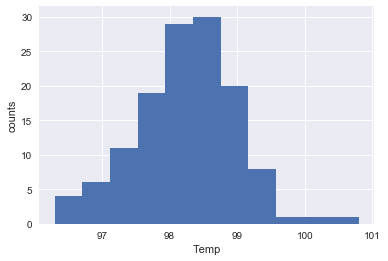

In [16]:
_ = plt.hist('temperature', data=df, bins=bins)
_ = plt.xlabel('Temp')
_ = plt.ylabel('counts')

Initial view suggests that data are normally distributed. We need to further confirm that by drawing a normal distributed samples from numpy

In [17]:
mu = np.mean(df.temperature)
sigma = np.std(df.temperature)
samples = np.random.normal(mu, sigma, 10000)

In [18]:
# Create a function to save typing time
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [19]:
x, y = ecdf(df.temperature)
x_theor, y_theor = ecdf(samples)

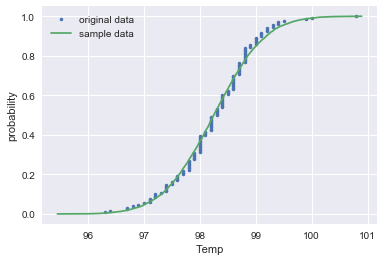

In [20]:
_ = plt.plot(x, y, marker='.', linestyle='none', label='original data')
_ = plt.plot(x_theor, y_theor, label='sample data')
_ = plt.xlabel('Temp')
_ = plt.ylabel('probability')
_ = plt.legend(loc='best')
plt.show()

The CDF curve for the dataset matches pretty well with the normal distributed sample set CDF.
We can conclude that the data collected are normal distributed.

#### Question 2

Given the sample show normal distribution and is greater than 30. We will conclude that the sample size is large enough.

Testing the independence of the observation - TBD